<a href="https://colab.research.google.com/github/naenumtou/learnTensorFlow/blob/main/OCRUsed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Change working
%cd /content/drive/My Drive/Colab Notebooks/ocr

/content/drive/My Drive/Colab Notebooks/ocr


In [3]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np

from imutils import grab_contours, resize
from imutils.contours import sort_contours
from tensorflow.keras.models import load_model

# Config
%config InlineBackend.figure_format = 'retina' #Retina display

In [4]:
# Load model
model = load_model('ocrResNet.model')

In [5]:
# Define show function
def showImage(data, convert = False, gray = True):
  plt.figure(figsize = (10, 6))
  if convert is True:
    data = data[:, :, ::-1] #BGR -> RGB
  if gray is True:
    color = 'gray'
  else:
    color = None
  plt.imshow(data, cmap = color)
  plt.axis('off')
  return plt.show()

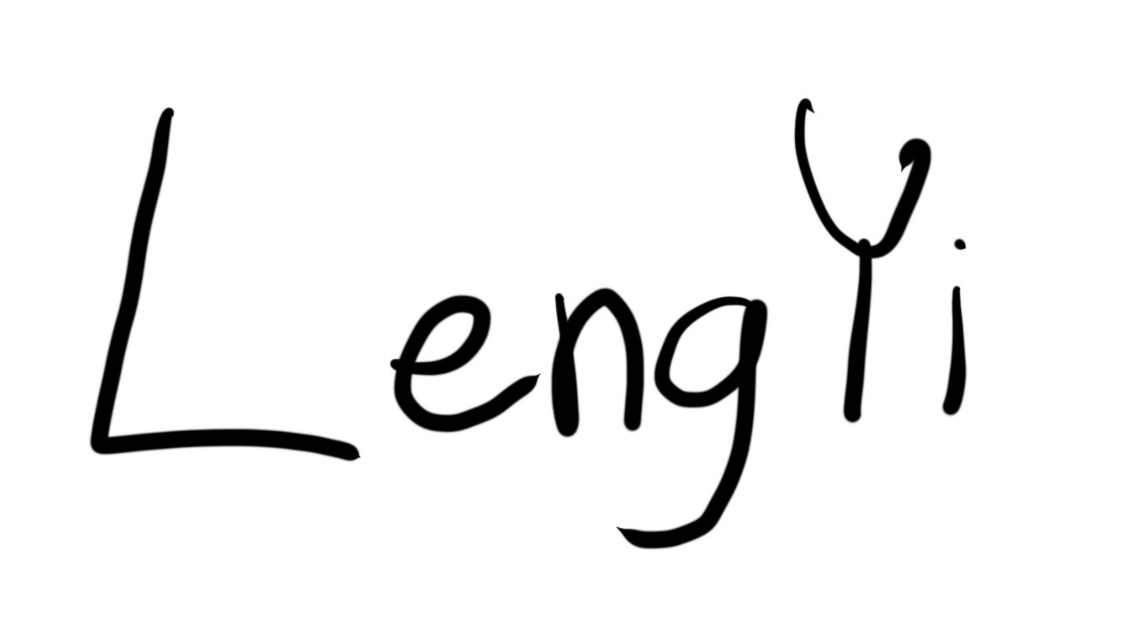

In [6]:
# Read image
image = cv2.imread('sampleImage.jpg')
showImage(image, convert = True, gray = False)

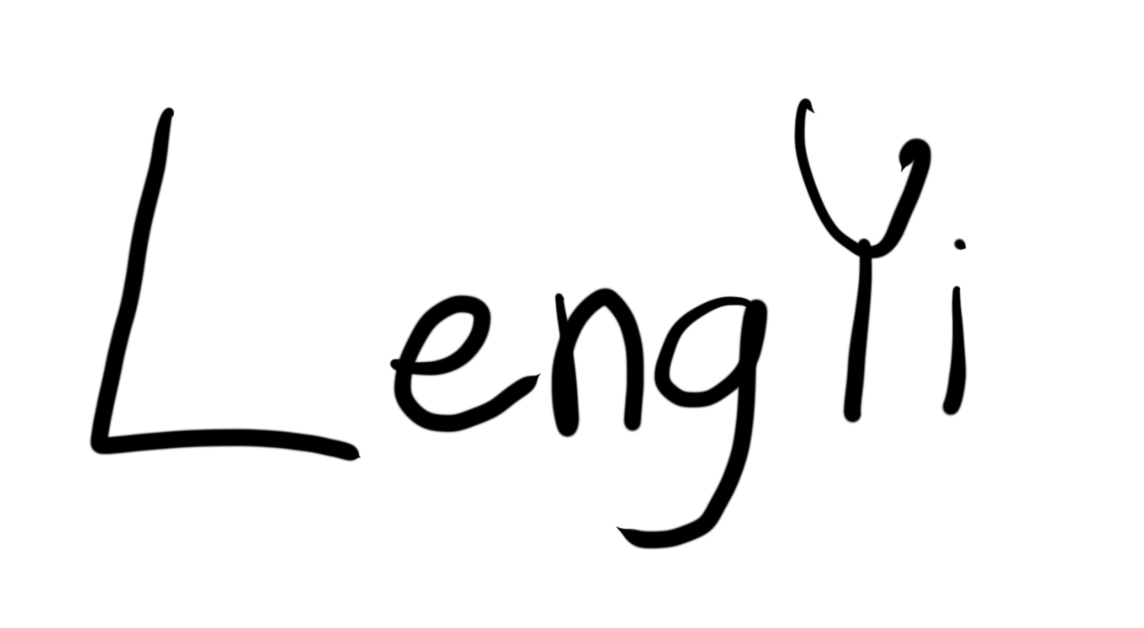

In [7]:
# Covert to gray scale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
showImage(gray, convert = False, gray = True)

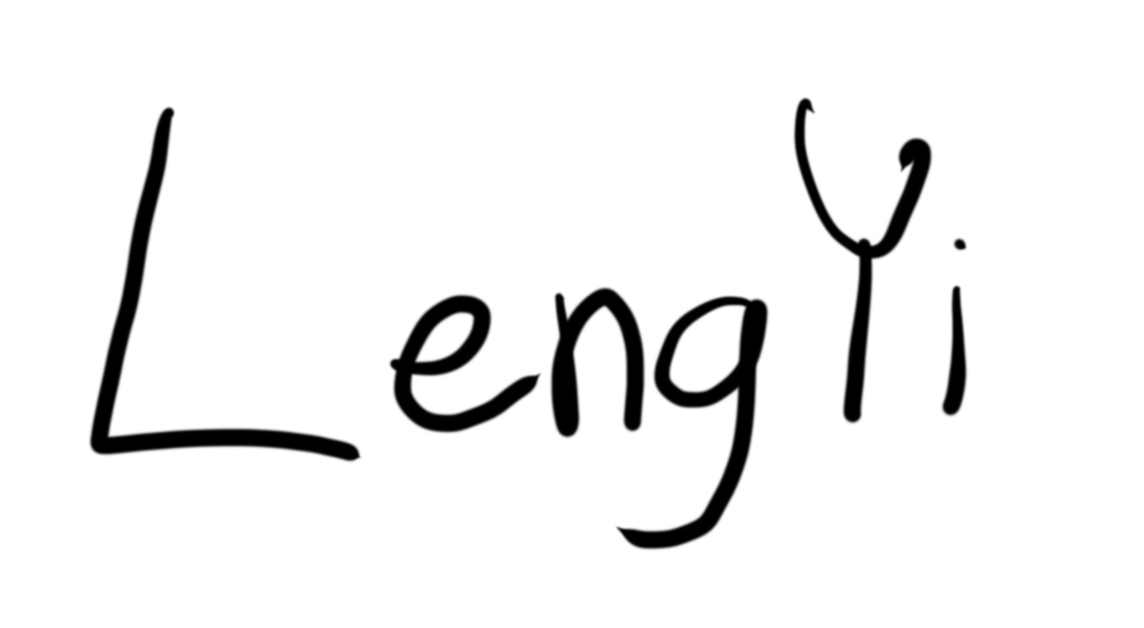

In [8]:
# Apply blur effect
blur = cv2.GaussianBlur(gray, (5, 5), 0)
showImage(blur, convert = False, gray = True)

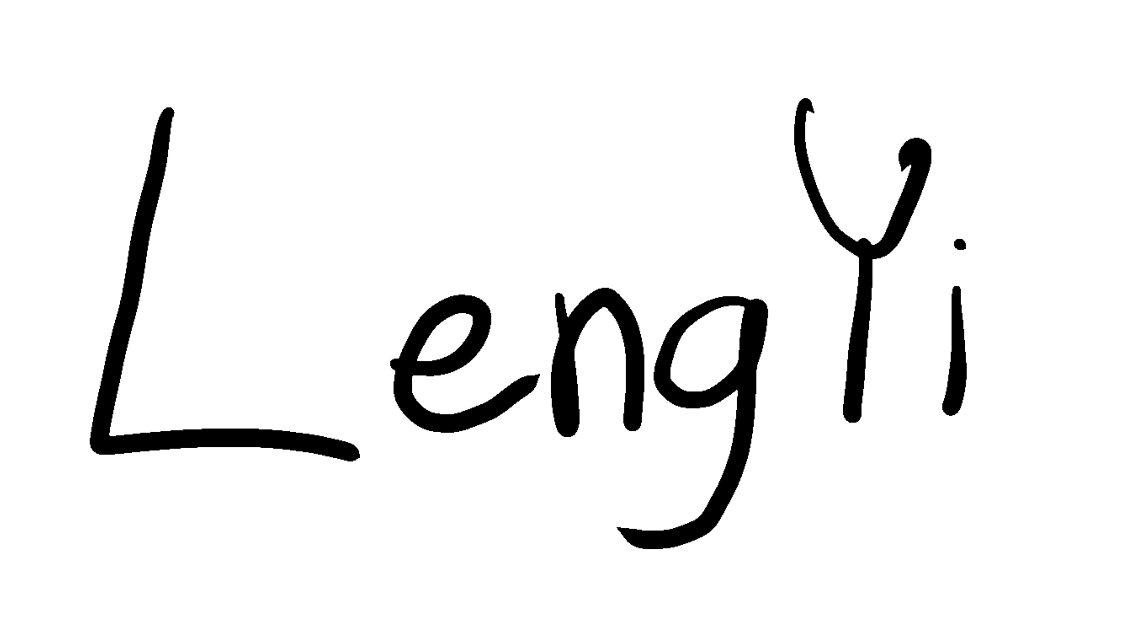

In [9]:
# Binary threshold
_, biThresh = cv2.threshold(blur, 180, 255, cv2.THRESH_BINARY)
showImage(biThresh, convert = False, gray = True)

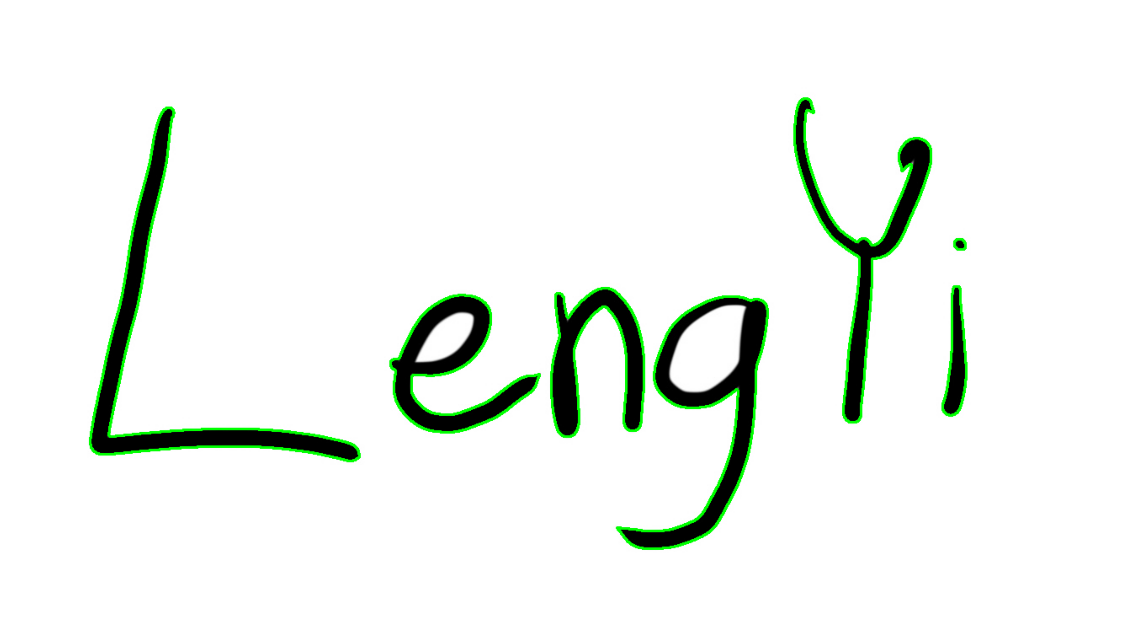

In [10]:
# Find contours
contours = cv2.findContours(
    image = 255 - biThresh.copy(), #Aviod to detect image frame
    mode = cv2.RETR_EXTERNAL,
	  method = cv2.CHAIN_APPROX_SIMPLE
)
contours = grab_contours(contours)
contours = sort_contours(contours, method = 'left-to-right')[0]
imageShow = image.copy() #Copy image to draw

# Draw contours in image
cv2.drawContours(
    image = imageShow, 
    contours = contours,
    contourIdx = -1,
    color = (0, 255, 0),
    thickness = 2
)
showImage(imageShow, convert = True, gray = False)

In [11]:
# Extract characters
chars = []
boxes = []
noises = []

for c in contours:
  (x, y, w, h) = cv2.boundingRect(c)
  if w >= 10 and h >= 20: #Aviod noise in image
    boxes.append((x, y, w, h)) #Keep box position for plotting
    pos = gray[y:y + h, x:x + w]
    _, bi = cv2.threshold(pos, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU) #Extract only image array
    # Resize to fit with ResNet50 Model (32, 32)
    (tH, tW) = bi.shape
    if tW > tH:
      bi = resize(bi, width = 32)
    else:
      bi = resize(bi, height = 32)
    (tH, tW) = bi.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)
    # Border image
    padded = cv2.copyMakeBorder(
        bi,
        top = dY, bottom = dY,
        left = dX, right = dX,
        borderType = cv2.BORDER_CONSTANT,
        value = (0, 0, 0)
    )
    char = cv2.resize(padded, (32, 32))
    char = char.astype(np.float32) / 255.0 #Normalised data array
    char = np.stack((char, ) * 3, axis = -1) #Expand gray to 3 Channels
    chars.append(char)
  else: #To keep noise to show
    noise = gray[y:y + h, x:x + w]
    noises.append(noise)

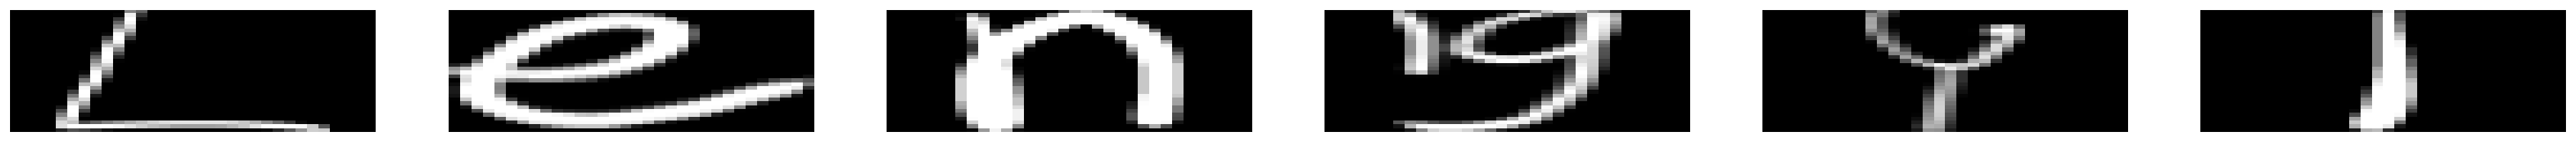

In [12]:
## Show image characters
plt.figure(figsize = (32, 4))
for i, _ in enumerate(chars):
  plt.subplot(1, len(chars), i + 1)
  plt.imshow(chars[i].reshape(32, -1), cmap = 'gray') #Images size (32 x 32)
  plt.axis('off')
plt.show()

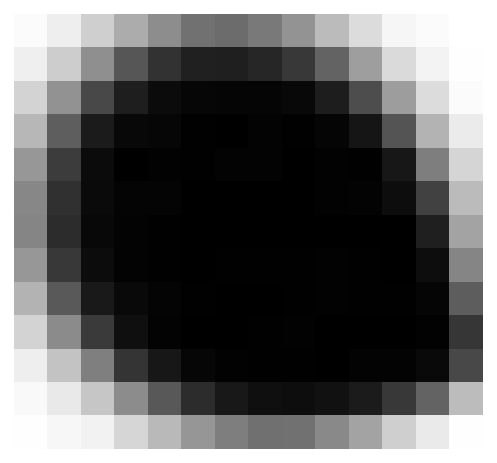

In [13]:
# Show noise in image
plt.figure(figsize = (32, 4))
for i, _ in enumerate(noises):
  plt.subplot(1, len(noises), i + 1)
  plt.imshow(noises[i], cmap = 'gray')
  plt.axis('off')
plt.show()

In [14]:
# To array
chars = np.array(chars)

# Label for prediction
labelNames = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# OCR from our model
preds = model.predict(chars, batch_size = 128).argmax(axis = 1)
probs = model.predict(chars).max(axis = 1)

In [15]:
# Apply to prediction to image
imageResult = image.copy()
for (pred, (x, y, w, h)) in zip(preds, boxes):
  label = labelNames[pred] #Return max index of probability
  cv2.rectangle(
      imageResult,
      (x, y),
      (x + w, y + h),
      (0, 255, 0),
      3
  )
  cv2.putText(
      imageResult, label,
      (x - 20, y - 10),
      cv2.FONT_HERSHEY_SIMPLEX,
      3,
      (0, 255, 0),
      2
  )
  print(f'Predict label: {label}')

Predict label: L
Predict label: C
Predict label: N
Predict label: 9
Predict label: Y
Predict label: 1


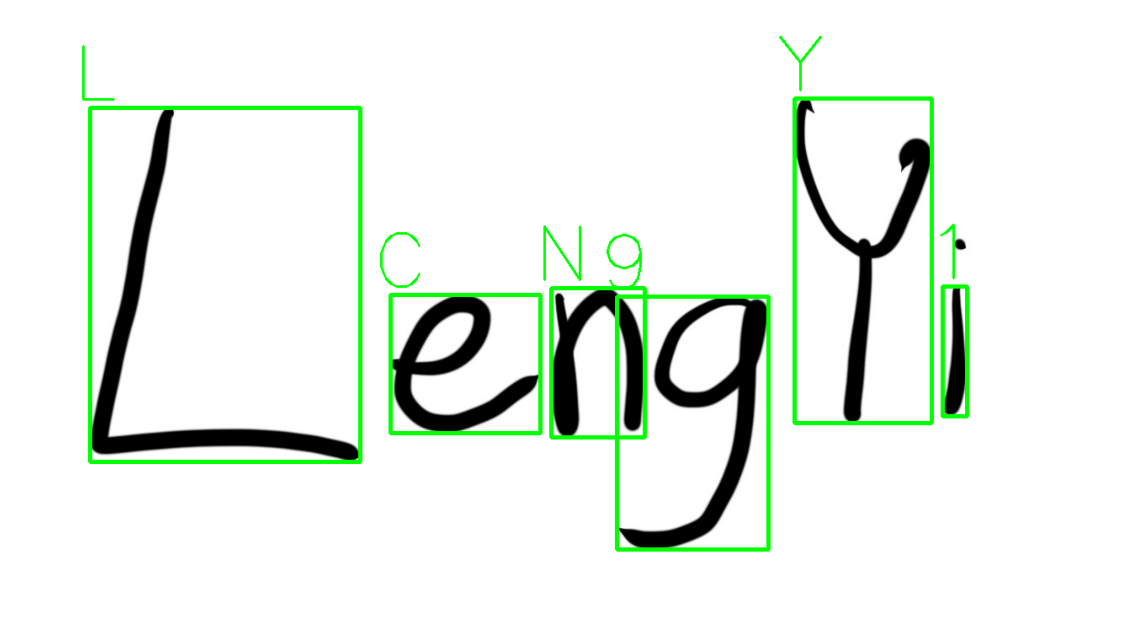

In [16]:
# Show result
showImage(imageResult, convert = True, gray = False)